In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#! mkdir ~/.kaggle

In [3]:
#!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json

In [4]:
#! kaggle datasets download nikitarom/planets-dataset

100% 1.50G/1.50G [01:38<00:00, 22.8MB/s]
100% 1.50G/1.50G [01:38<00:00, 16.4MB/s]


In [5]:
#! unzip planets-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: test-jpg-additional/test-jpg-additional/file_5499.jpg  
  inflating: test-jpg-additional/test-jpg-additional/file_55.jpg  
  inflating: test-jpg-additional/test-jpg-additional/file_550.jpg  
  inflating: test-jpg-additional/test-jpg-additional/file_5500.jpg  
  inflating: test-jpg-additional/test-jpg-additional/file_5501.jpg  
  inflating: test-jpg-additional/test-jpg-additional/file_5502.jpg  
  inflating: test-jpg-additional/test-jpg-additional/file_5503.jpg  
  inflating: test-jpg-additional/test-jpg-additional/file_5504.jpg  
  inflating: test-jpg-additional/test-jpg-additional/file_5505.jpg  
  inflating: test-jpg-additional/test-jpg-additional/file_5506.jpg  
  inflating: test-jpg-additional/test-jpg-additional/file_5507.jpg  
  inflating: test-jpg-additional/test-jpg-additional/file_5508.jpg  
  inflating: test-jpg-additional/test-jpg-additional/file_5509.jpg  
  inflating: test-jpg-additional/test-jpg-additional/fi

In [6]:
!ls /content/planet/planet

sample_submission.csv  test-jpg  train_classes.csv  train-jpg


**Importing the necessary libraries**

In [7]:
import os
import random
from time import time
from glob import glob
from tqdm.notebook import tqdm
import dill as pickle
from collections import Counter
import gc
import pathlib
import subprocess
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.image as mpimg
import scipy
from skimage import io
from scipy import ndimage
from IPython.display import display

import cv2
from multiprocessing import Pool, cpu_count

from plotly import graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
from plotly.subplots import make_subplots


# To make this notebook stable across runs, we set random seeding
# for reproducibility purposes
random.seed(1)
np.random.seed(1)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)


import tensorflow as tf
from tensorflow import keras

from keras import models
from keras.models import Sequential
from keras.applications.vgg16 import VGG16
from keras.layers import Conv2D, MaxPooling2D


from keras.layers import Dense, Dropout, Flatten, BatchNormalization
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from sklearn.utils import shuffle
from sklearn.metrics import fbeta_score
from sklearn.model_selection import train_test_split 


In [8]:
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Default GPU Device: /device:GPU:0


**Data Exploration**

Label Distribution

In [9]:
#Let's first load the training dataset and quantify the label distributions
path = "/content/planet/planet"
path_train = os.path.join(path, "train-jpg")
path_test = os.path.join(path, "test-jpg")
print(
    f"train files: {len(os.listdir(path_train))}, "
    f"test files: {len(os.listdir(path_test))}"
)

train files: 40479, test files: 40669


In [10]:
path_class = os.path.join(path, "train_classes.csv")
df_class = pd.read_csv(path_class)
print(df_class.shape)
df_class.head()

(40479, 2)


,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


**Simple counter of individual label, by splitting them from tags**

In [11]:
df_class["list_tags"] = df_class.tags.str.split(" ")
row_tags = df_class.list_tags.values
tags = [tag for row in row_tags for tag in row]
counter_tags = Counter(tags)
df_tags = pd.DataFrame(
    {"tag": counter_tags.keys(), "total": counter_tags.values()}
).sort_values("total")

fig = px.bar(df_tags, x="total", y="tag", orientation="h", 
             color="total",
)
fig.update_layout(title="Class distribution")
fig.show()

As expected, some classes are largely representated whereas some are barely present in this dataset. There is an important risk that our model barely learn the rare classes or even to exclude them from the training data upon splitting between training and validating sets. We identify clearly theses classes for latter investigation.

In [12]:
RARE_CLASSES = [
    "bare_ground", "selective_logging", "artisinal_mine", "blooming", "slash_burn", "blow_down", "conventional_mine"
]

**Class Visualization**

Let's now observe each label invidually. Each image is mapped to a list of labels, with a total of 17 different labels.
For sake of clarity, I only displayed one label per image on the figure below. When images are associated to multiple labels, I displayed them multiple times

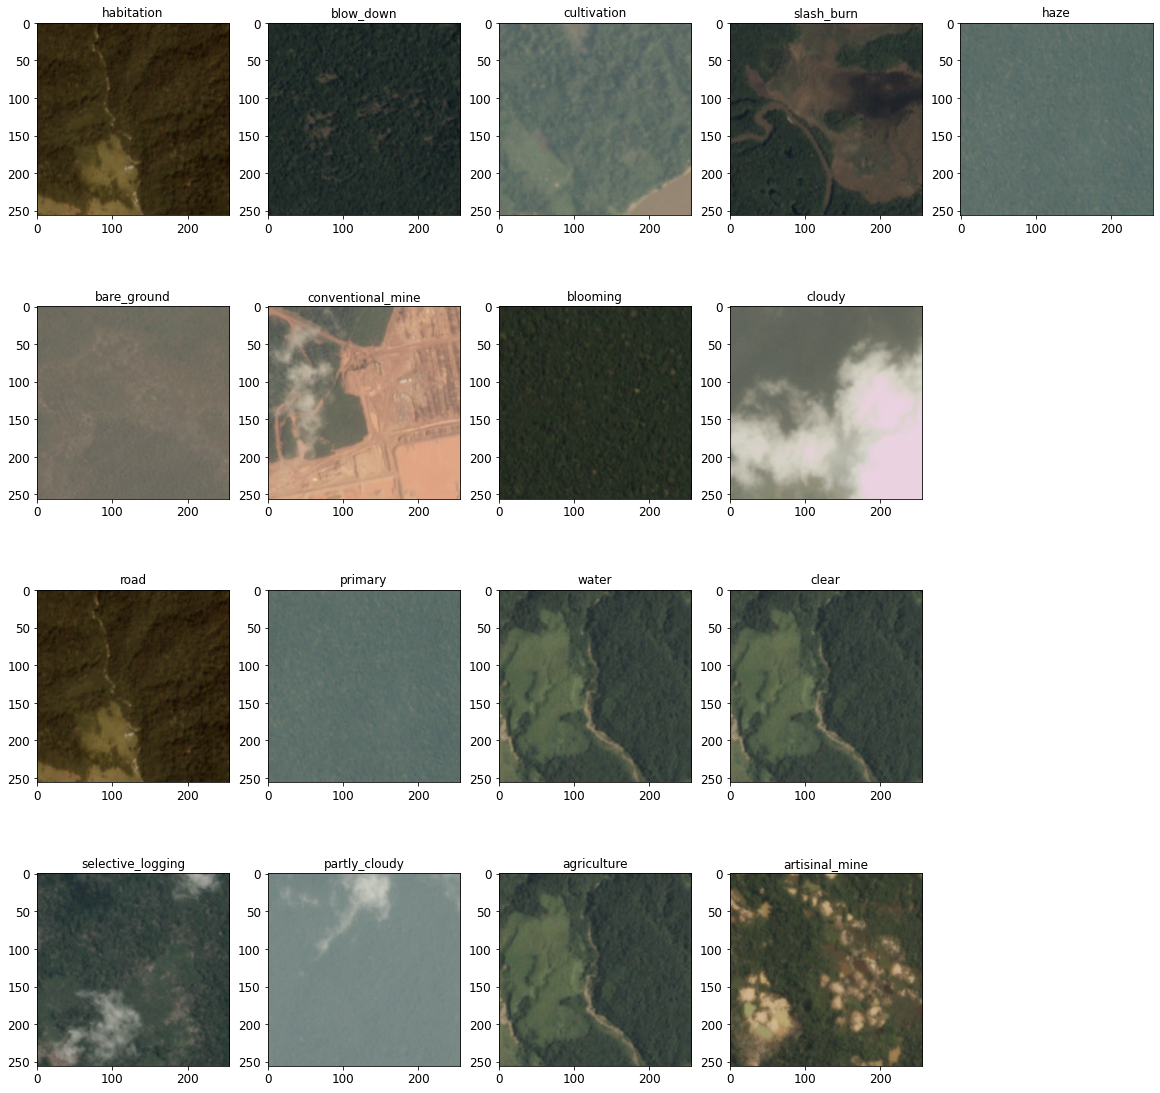

In [13]:
all_tags = list(set(tags))
N_tags = len(all_tags)
fig, axes = plt.subplots(4, (N_tags//4)+1, figsize=(20, 20))
for idx, tag in enumerate(all_tags):
    filename = df_class.loc[df_class.tags.str.contains(tag)].image_name.values[0]
    img = cv2.imread(os.path.join(path_train, filename+".jpg"))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    idx_col = idx // 4
    idx_row = idx % 4
    axes[idx_row][idx_col].set_title(tag)
    axes[idx_row][idx_col].imshow(img)
axes[1][-1].remove()
axes[2][-1].remove()
axes[3][-1].remove()

### #load csv

In [14]:
train_df = pd.read_csv('/content/planet/planet/train_classes.csv')
test_df = pd.read_csv('/content/planet/planet/sample_submission.csv')

In [16]:
train_classes = train_df[:]['tags']

no_classes = len(train_classes.unique())
print(f'Given {len(train_classes)} samples, there are {no_classes} unique classes.', '\n')


Given 40479 samples, there are 449 unique classes. 



In [17]:
# Normalizing the tags
flatten = lambda l: [item for sublist in l for item in sublist]
labels = list(set(flatten([l.split(' ') for l in train_df['tags'].values])))

# Creating a key(dict) to numerically categorize labels
label_map = {l: i for i, l in enumerate(labels)}
print(f'labels = {labels},\n length = {len(labels)}', '\n')

print(f'label_map = {label_map},\n length = {len(label_map)}')

labels = ['habitation', 'bare_ground', 'road', 'selective_logging', 'blow_down', 'conventional_mine', 'primary', 'partly_cloudy', 'cultivation', 'blooming', 'water', 'agriculture', 'slash_burn', 'cloudy', 'clear', 'artisinal_mine', 'haze'],
 length = 17 

label_map = {'habitation': 0, 'bare_ground': 1, 'road': 2, 'selective_logging': 3, 'blow_down': 4, 'conventional_mine': 5, 'primary': 6, 'partly_cloudy': 7, 'cultivation': 8, 'blooming': 9, 'water': 10, 'agriculture': 11, 'slash_burn': 12, 'cloudy': 13, 'clear': 14, 'artisinal_mine': 15, 'haze': 16},
 length = 17


In [18]:
for f, tags in train_df[:9].values:
    img = cv2.imread('/content/planet/planet/train-jpg/{}.jpg'.format(f))

### **Loading the train-jpg files**

In [19]:
train_img_dir = pathlib.Path('/content/planet/planet/train-jpg')
test_img_dir = pathlib.Path('/content/planet/planet/test-jpg')
test_add_img_dir = pathlib.Path('/content/test-jpg-additional/test-jpg-additional')

train_img_path = sorted(list(train_img_dir.glob('*.jpg')))

train_img_count = len(train_img_path)

print('Number of image chip for train: ', str(train_img_count))

Number of image chip for train:  40479


In [20]:
# first test jpg file path

test_img_path = sorted(list(test_img_dir.glob('*.jpg')))

test_img_count = len(test_img_path)
print('Number of image chip for test: ',str(test_img_count))

Number of image chip for test:  40669


In [21]:
# second test jpg file path

test_add_img_path = sorted(list(test_add_img_dir.glob('*.jpg')))

test_add_img_count = len(test_add_img_path)
print('Number of chip for additional test: ',str(test_add_img_count))

Number of chip for additional test:  20522


In [22]:
#check if the number of jpg images equals the number of samples in the csv file for each datase

# train
if len(train_img_path) == len(train_df):
    print('Training dataset with the same amount of samples listed in csv')

#if not equal execution stops here
assert len(train_img_path) == len(train_df) 


# test
if len(test_img_path)+len(test_add_img_path) == len(test_df):
    print('Test dataset with the same amount of samples listed in csv')

#if not equal execution stops here
assert len(test_img_path)+len(test_add_img_path) == len(test_df)

Training dataset with the same amount of samples listed in csv
Test dataset with the same amount of samples listed in csv


**Data Preprocessing**

#convert the test images to pixels and resize them as well

In [23]:
input_size = 64
input_channels = 3

batch_size = 64

In [24]:
x_train = []
y_train = []
for f, tags in tqdm(train_df.values, miniters=1000):
    img = cv2.imread('/content/planet/planet/train-jpg/{}.jpg'.format(f))
    img = cv2.resize(img, (input_size, input_size))
    targets = np.zeros(17)
    for t in tags.split(' '):
        targets[label_map[t]] = 1
    x_train.append(img)
    y_train.append(targets)
        
x_train = np.array(x_train, np.float32)
y_train = np.array(y_train, np.uint8)

print(x_train.shape)
print(y_train.shape)

  0%|          | 0/40479 [00:00<?, ?it/s]

(40479, 64, 64, 3)
(40479, 17)


In [25]:
x_test = []

test_image_names = os.listdir(test_img_dir)

n_test = len(test_image_names)
test_classes = test_df.iloc[:n_test, :]
add_classes = test_df.iloc[n_test:, :]

test_add_image_names = os.listdir(test_add_img_dir)

for img_name, _ in tqdm(test_classes.values, miniters=1000):
    img = cv2.imread(str(test_img_dir) + '/{}.jpg'.format(img_name))
    x_test.append(cv2.resize(img, (64, 64)))
    
for img_name, _ in tqdm(add_classes.values, miniters=1000):
    img = cv2.imread(str(test_add_img_dir) + '/{}.jpg'.format(img_name))
    x_test.append(cv2.resize(img, (64, 64)))

x_test = np.array(x_test, np.float32)
print(x_test.shape)

  0%|          | 0/40669 [00:00<?, ?it/s]

  0%|          | 0/20522 [00:00<?, ?it/s]

(61191, 64, 64, 3)


In [26]:
X_train, X_valid, Y_train, Y_valid = train_test_split(x_train, y_train, test_size=0.2)

**Building the model**

### Using VGG16 as Base model

In [27]:
base_model = VGG16(include_top=False,
                   weights='imagenet',
                   input_shape=(input_size, input_size, input_channels))

model = Sequential()
model.add(BatchNormalization(input_shape=(input_size, input_size, input_channels)))

model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.5))

model.add(Dense(17, activation='sigmoid'))

58900480/58889256 [==============================] - 2s 0us/step


In [28]:
model.compile(loss='binary_crossentropy',optimizer="SGD", metrics=['accuracy'])
    
callbacks = [EarlyStopping(monitor='val_loss', patience=2, verbose=0),
                ModelCheckpoint(filepath='weights/best_weights',
                                 save_best_only=True,
                                 save_weights_only=True)]
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 64, 64, 3)        12        
 ormalization)                                                   
                                                                 
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 17)                34833     
                                                                 
Total params: 14,749,533
Trainable params: 14,749,527
Non-trainable params: 6
____________________________________________

In [29]:
history = model.fit(x=X_train, y=Y_train, validation_data=(X_valid, Y_valid),
                  batch_size=batch_size,verbose=2, epochs=15,callbacks=callbacks,shuffle=True)

Epoch 1/15
506/506 - 105s - loss: 0.1855 - accuracy: 0.6316 - val_loss: 0.1349 - val_accuracy: 0.6835 - 105s/epoch - 207ms/step
Epoch 2/15
506/506 - 87s - loss: 0.1403 - accuracy: 0.6258 - val_loss: 0.1213 - val_accuracy: 0.6700 - 87s/epoch - 173ms/step
Epoch 3/15
506/506 - 87s - loss: 0.1277 - accuracy: 0.6186 - val_loss: 0.1149 - val_accuracy: 0.6550 - 87s/epoch - 173ms/step
Epoch 4/15
506/506 - 87s - loss: 0.1214 - accuracy: 0.6196 - val_loss: 0.1120 - val_accuracy: 0.6458 - 87s/epoch - 173ms/step
Epoch 5/15
506/506 - 87s - loss: 0.1164 - accuracy: 0.6193 - val_loss: 0.1088 - val_accuracy: 0.6675 - 87s/epoch - 173ms/step
Epoch 6/15
506/506 - 87s - loss: 0.1131 - accuracy: 0.6231 - val_loss: 0.1060 - val_accuracy: 0.6516 - 87s/epoch - 173ms/step
Epoch 7/15
506/506 - 87s - loss: 0.1098 - accuracy: 0.6169 - val_loss: 0.1050 - val_accuracy: 0.6706 - 87s/epoch - 173ms/step
Epoch 8/15
506/506 - 87s - loss: 0.1080 - accuracy: 0.6283 - val_loss: 0.1063 - val_accuracy: 0.6742 - 87s/epoch - 1

In [30]:
model.save('./models/vgg16-amazon2')

INFO:tensorflow:Assets written to: ./models/vgg16-amazon2/assets


In [32]:
model_back = models.load_model("./models/vgg16-amazon2")

In [33]:
p_valid = model_back.predict(X_valid, batch_size = batch_size, verbose=1)

print('Accuracy: ',fbeta_score(Y_valid, np.array(p_valid) > 0.18, beta=2, average='samples'))

127/127 [==============================] - 7s 52ms/step
Accuracy:  0.9080640271118471


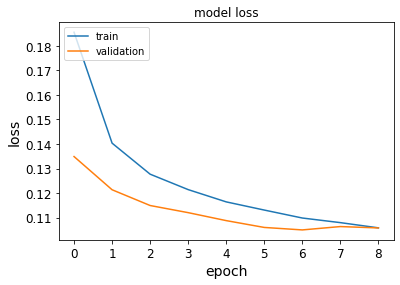

In [34]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [35]:
y_pred = []
p_test = model_back.predict(x_test, batch_size=batch_size, verbose=2)
y_pred.append(p_test)

957/957 - 50s - 50s/epoch - 52ms/step


In [36]:
result = np.array(y_pred[0])
for i in range(1, len(y_pred)):
    result += np.array(y_pred[i])
result = pd.DataFrame(result, columns=labels)

In [37]:
# Translating the probability predictions to the unique labels
preds = []
for i in tqdm(range(result.shape[0]), miniters=1000):
    a = result.loc[[i]]
    a = a.apply(lambda x: x>0.2, axis=1)
    a = a.transpose()
    a = a.loc[a[i] == True]
    ' '.join(list(a.index))
    preds.append(' '.join(list(a.index)))

  0%|          | 0/61191 [00:00<?, ?it/s]

In [38]:
# Replacing the tags columns with the predicted labels
test_df['tags'] = preds
test_df.head()

,image_name,tags
0,test_0,primary clear
1,test_1,primary clear
2,test_2,primary partly_cloudy
3,test_3,primary clear
4,test_4,primary partly_cloudy cloudy


In [39]:
# Converting the dataframe to a csv file for submission
test_df.to_csv('HDSC_StageD_Cohort22_results.csv', index=False)

***THANK YOU ♈***